<a href="https://colab.research.google.com/github/sakalaharshith/Capuchin-Bird-Deep-Audio-Detection/blob/main_branch/Capuchin_Bird_Deep_Audio_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
! pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.3.3
branca

In [ ]:
pip install tensorflow-io==0.26.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from zipfile import ZipFile
foldername_large_dataset="/content/archive (7).zip"
with ZipFile(foldername_large_dataset,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio

In [ ]:
CAPUCHIN_FILE=os.path.join("data","Parsed_Capuchinbird_Clips","XC3776-3.wav")
NON_CAPUCHIN_FILE=os.path.join("data","Parsed_Not_Capuchinbird_Clips","Crickets-chirping-1.wav")

In [ ]:
def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_contents=tf.io.read_file(filename)
  # Decode wav using tensors by channels. here i am going with mono audio channel as it is easy to process it to make a spectogram.
  wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
  #Removing trailing axis
  wav=tf.squeeze(wav,axis=-1)
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)
  # changing the frequency per sec from 44100 hz to 16000 hz
  wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
  return wav

In [ ]:
wave=load_wav_16k_mono(CAPUCHIN_FILE)
nwave=load_wav_16k_mono(NON_CAPUCHIN_FILE)

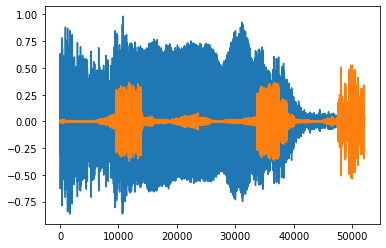

In [ ]:
plt.plot(wave)
plt.plot(nwave)

plt.show()


In [ ]:
POS=os.path.join('data','Parsed_Capuchinbird_Clips')
print(POS)
NEG=os.path.join('data','Parsed_Not_Capuchinbird_Clips')
print(NEG)

data/Parsed_Capuchinbird_Clips
data/Parsed_Not_Capuchinbird_Clips


In [ ]:
pos=tf.data.Dataset.list_files(POS+'/*.wav')
print(len(pos))
neg=tf.data.Dataset.list_files(NEG+'/*.wav')
print(len(neg))


217
593


In [ ]:
positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data=positives.concatenate(negatives)


In [ ]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/curlew-sound-2.wav', 0.0)

In [ ]:
lengths=[]
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
  tensor_wave=load_wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))   

In [ ]:
lengths


[56000,
 64000,
 40000,
 56000,
 64000,
 72000,
 48000,
 64000,
 64000,
 56000,
 56000,
 48000,
 40000,
 56000,
 48000,
 48000,
 48000,
 56000,
 64000,
 64000,
 40000,
 72000,
 48000,
 40000,
 48000,
 64000,
 64000,
 40000,
 56000,
 56000,
 48000,
 64000,
 56000,
 56000,
 64000,
 64000,
 64000,
 48000,
 56000,
 56000,
 56000,
 40000,
 64000,
 56000,
 48000,
 48000,
 56000,
 64000,
 64000,
 48000,
 40000,
 48000,
 64000,
 72000,
 48000,
 56000,
 56000,
 48000,
 32000,
 40000,
 56000,
 40000,
 56000,
 56000,
 40000,
 72000,
 56000,
 56000,
 56000,
 48000,
 56000,
 48000,
 56000,
 56000,
 48000,
 64000,
 55999,
 56000,
 48000,
 56000,
 48000,
 56000,
 56000,
 56000,
 56000,
 48000,
 56000,
 72000,
 40000,
 56000,
 56000,
 64000,
 56000,
 48000,
 48000,
 64000,
 56000,
 56000,
 55999,
 48000,
 56000,
 64000,
 64000,
 64000,
 64000,
 56000,
 40000,
 40000,
 48000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 48000,
 64000,
 56000,
 56000,
 56000,
 56000,


In [ ]:
def preprocess(file_path,label):
  wav=load_wav_16k_mono(file_path)
  wav=wav[:48000]
  zero_padding=tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
  wav=tf.concat([zero_padding,wav],0)
  spectogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectogram=tf.abs(spectogram)
  spectogram=tf.expand_dims(spectogram,axis=2)
  return spectogram,label

In [ ]:
filepath,label=positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectogram,label=preprocess(filepath,label)

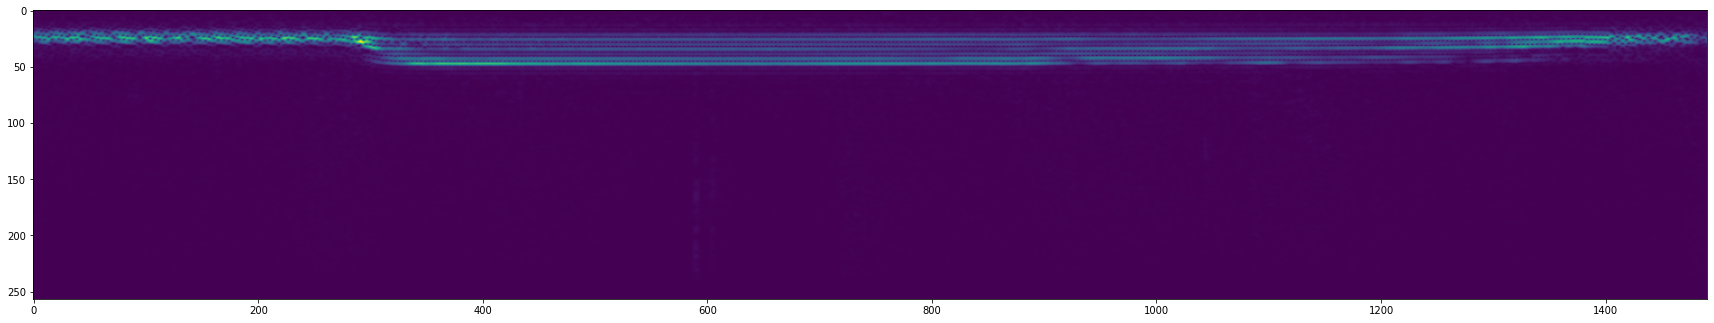

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [ ]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)


In [ ]:
len(data)

51

In [ ]:
train=data.take(36)
test=data.skip(36).take(15)

In [ ]:
samples,labels=train.as_numpy_iterator().next()

In [ ]:
samples.shape 

(16, 1491, 257, 1)

In [ ]:
labels

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense,Flatten

In [ ]:
model=Sequential()
model.add(Conv2D(20,(3,3),activation='relu',input_shape=(1491,257,1)))
model.add(Conv2D(30,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.compile('Adam',loss='BinaryCrossentropy',metrics=[tf.metrics.Recall(),tf.metrics.Precision()])


In [ ]:
model.summary()

model.save_weights("model (1).h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 20)     200       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 30)     5430      
                                                                 
 flatten (Flatten)           (None, 11286330)          0         
                                                                 
 dense (Dense)               (None, 50)                564316550 
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 564,322,231
Trainable params: 564,322,231
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist=model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
36/36 [==============================] - 23s 381ms/step - loss: 2.6029 - recall: 0.8634 - precision: 0.8274 - val_loss: 0.0636 - val_recall: 1.0000 - val_precision: 0.9839
Epoch 2/5
36/36 [==============================] - 13s 363ms/step - loss: 0.1958 - recall: 0.9408 - precision: 0.9470 - val_loss: 0.0059 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/5
36/36 [==============================] - 13s 367ms/step - loss: 0.0168 - recall: 0.9868 - precision: 0.9934 - val_loss: 0.0058 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/5
36/36 [==============================] - 13s 364ms/step - loss: 0.0030 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0124 - val_recall: 0.9815 - val_precision: 1.0000
Epoch 5/5
36/36 [==============================] - 13s 359ms/step - loss: 8.4898e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0056 - val_recall: 0.9841 - val_precision: 1.0000


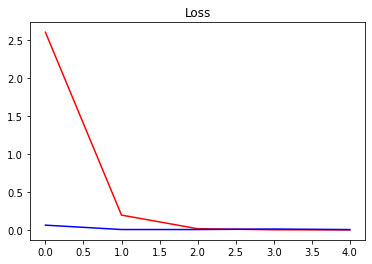

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

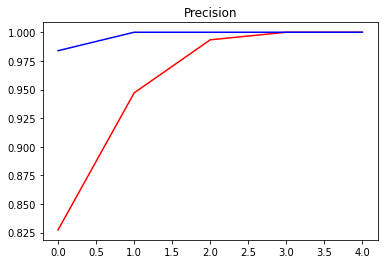

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'],'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

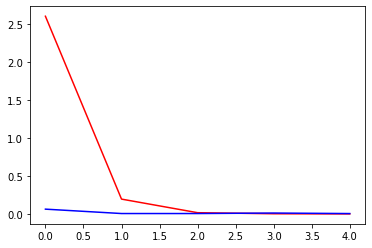

In [ ]:
plt.title('')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

In [ ]:
x_test,y_test=test.as_numpy_iterator().next()

In [ ]:
output=model.predict(x_test)

1/1 [==============================] - 0s 86ms/step


In [ ]:
print(output)


[[4.5644777e-09]
 [1.0000000e+00]
 [6.8610206e-07]
 [1.0087240e-04]
 [9.9999809e-01]
 [9.2646842e-05]
 [1.3017976e-08]
 [3.3610786e-04]
 [3.6818520e-10]
 [1.0868604e-09]
 [9.9986148e-01]
 [1.3573895e-06]
 [9.9909103e-01]
 [2.5548599e-05]
 [9.7417202e-13]
 [4.4417475e-13]]


In [ ]:
output=[1 if prediction > 0.90 else 0 for prediction in output]

In [ ]:
print(output)
print(y_test)

[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
tf.math.reduce_sum(output)
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [ ]:
def load_mp3_16k_mono(filename):
  res=tfio.audio.AudioIOTensor(filename)
  tensor=res.to_tensor()
  tensor=tf.reduce_sum(tensor,axis=1)/2
  sample_rate=res.rate
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)
  wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
  return wav

In [ ]:
mp3=os.path.join('data','Forest Recordings','recording_00.mp3')

In [ ]:
wav=load_mp3_16k_mono(mp3)



In [ ]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

In [ ]:
samples,index=audio_slices.as_numpy_iterator().next()
print(len(audio_slices))


60


In [ ]:
def preprocess_mp3(sample,index):
  sample=sample[0]
  zero_padding=tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
  wav=tf.concat([zero_padding,sample],0)
  spectogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectogram=tf.abs(spectogram)
  spectogram=tf.expand_dims(spectogram,axis=2)
  return spectogram

In [ ]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
audio_slices=audio_slices.map(preprocess_mp3)
audio_slices=audio_slices.batch(60)

In [ ]:
model.load_weights("/content/model (1).h5")

In [ ]:
output=model.predict(audio_slices)
output=[1 if prediction > 0.90 else 0 for prediction in output]


1/1 [==============================] - 8s 8s/step


In [ ]:
print(output)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from itertools import groupby

In [ ]:
output=[key for key,group in groupby(output)]
calls=tf.math.reduce_sum(output).numpy()

In [ ]:
print(calls)

5


In [ ]:
results={}
for file in os.listdir(os.path.join('data',"Forest Recordings")):
  FILEPATH=os.path.join("data","Forest Recordings",file)
  wav=load_mp3_16k_mono(FILEPATH)
  audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
  audio_slices=audio_slices.map(preprocess_mp3)
  audio_slices=audio_slices.batch(64)
  output=model.predict(audio_slices)
  results[file]=output


1/1 [==============================] - 1s 1s/step


In [ ]:
results

{'recording_45.mp3': array([[1.2719653e-03],
        [1.0345213e-04],
        [4.1345600e-04],
        [1.3532942e-04],
        [7.3482492e-04],
        [3.2464648e-03],
        [2.2065095e-04],
        [5.9358450e-04],
        [2.0954502e-03],
        [3.8313749e-05],
        [4.0546843e-04],
        [2.5453226e-04],
        [5.4523050e-05],
        [2.4315240e-04],
        [9.8756654e-04],
        [3.4962584e-05],
        [6.0019107e-04],
        [4.5375092e-04],
        [9.2415314e-04],
        [3.8615728e-04],
        [1.7347574e-02],
        [1.0000000e+00],
        [1.7440899e-03],
        [9.3722201e-06],
        [6.1245862e-04],
        [9.7320066e-04],
        [6.6031047e-05],
        [3.1364034e-04],
        [4.1737070e-04],
        [1.1450936e-04],
        [2.4343377e-04],
        [5.8027892e-04],
        [2.4812645e-04],
        [6.6880242e-04],
        [7.8935502e-04],
        [3.6618803e-04],
        [6.1610655e-04],
        [1.8748701e-04],
        [4.9171373e-05],
     

In [ ]:
class_preds={}
for file,logits in results.items():
  class_preds[file]=[1 if prediction >0.99 else 0 for prediction in logits]
class_preds 

{'recording_45.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0],
 'recording_06.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_69.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_88.mp3': [0,
  0,
  0,
  

In [ ]:
postprocessed={}
for file,scores in class_preds.items():
  postprocessed[file]=tf.math.reduce_sum([key for key,group in groupby(scores)])

In [ ]:
postprocessed
                                               

{'recording_45.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 'recording_06.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_69.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_88.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_97.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 'recording_99.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_00.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_12.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_25.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 'recording_18.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 'recording_84.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_29.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=16>,
 'recording_23.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_31.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_94.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 'recordi